<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>


In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

// needed to generate the Table of contents 
// taken from github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

In [2]:
#To work with Atom and Jupyter at the same time

%load_ext autoreload
%autoreload 2

In [17]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
#from matplotlib import gridspec #gridspec allows me to make a subplot with different aspect ratio
#from IPython.display import Image #used to display images saved to disk

sns.set() #setting default Seaborn plot style

In [4]:
import pandas_profiling
from pandas_profiling.utils.cache import cache_file

In [5]:
from sklearn.cluster import KMeans

import numpy as np


In [45]:
from IPython.display import Image #used to display images saved to disk

In [6]:
os.chdir('..')
print(os.getcwd())

/home/andrea/Dropbox/PyProjects/Predictive_Maintenance_Fanjet


In [7]:
filename = 'train.csv' 
#try also 'data/test.csv' and 'data/RUL.csv' for similar results
file_path = 'data/'+filename
df = pd.read_csv(file_path)

In [8]:
df.head(5)

,unit_number,cycle_time,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,dataset
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,FD003
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,FD003
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,FD003
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,FD003
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,FD003


# Exploratory Data Analysis

## Explore Data Relationships


In [9]:
# for convenience, identify the sensor and operational setting columns
s_columns = [col for col in df.columns if col.startswith("s")]
op_setting_columns = [col for col in df.columns if col.startswith("op_setting")]
data_cols = op_setting_columns + s_columns

Generate Pairplot of Operating columns

In [ ]:
# pair plot takes way too long there are too many variables

#sns.pairplot(df[s_columns])

### Automatic report with pandas-profiling

In [ ]:
profile_report = df.profile_report(html={'style': {'full_width': True}},progress_bar=False)
profile_report.to_file("figures/data_profiling_report.html")
profile_report

**Takeaways :** Many sensor readings are fairly constant and probably will not be good predictors of the Remaning Usable Life.

### Operating Conditions

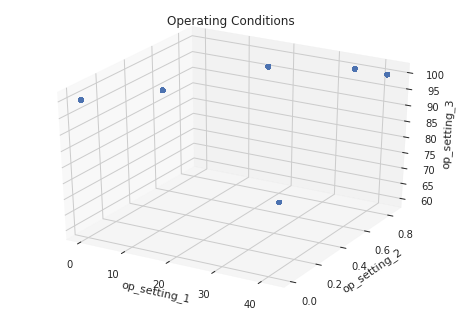

In [10]:
sns.set_style("whitegrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df[op_setting_columns[0]],df[op_setting_columns[1]],df[op_setting_columns[2]])
ax.set_xlabel(op_setting_columns[0])
ax.set_ylabel(op_setting_columns[1])
ax.set_zlabel(op_setting_columns[2])
ax.set_title('Operating Conditions')
plt.show()

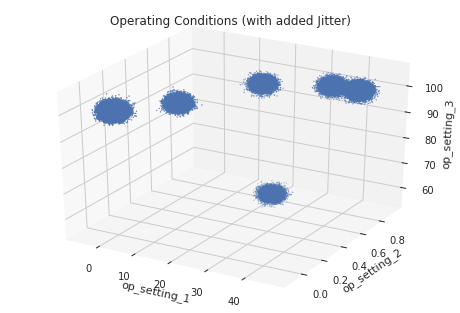

In [11]:
def rand_jitter(arr):
    stdev = .03*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


sns.set_style("whitegrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rand_jitter(df[op_setting_columns[0]].values),rand_jitter(df[op_setting_columns[1]].values),rand_jitter(df[op_setting_columns[2]].values), s=1)
ax.set_xlabel(op_setting_columns[0])
ax.set_ylabel(op_setting_columns[1])
ax.set_zlabel(op_setting_columns[2])
ax.set_title('Operating Conditions (with added Jitter)')
plt.show()

**Takeaways :** We observe that the Operating condistions are clustered in 6 operating regimes.

### Sensor Readings

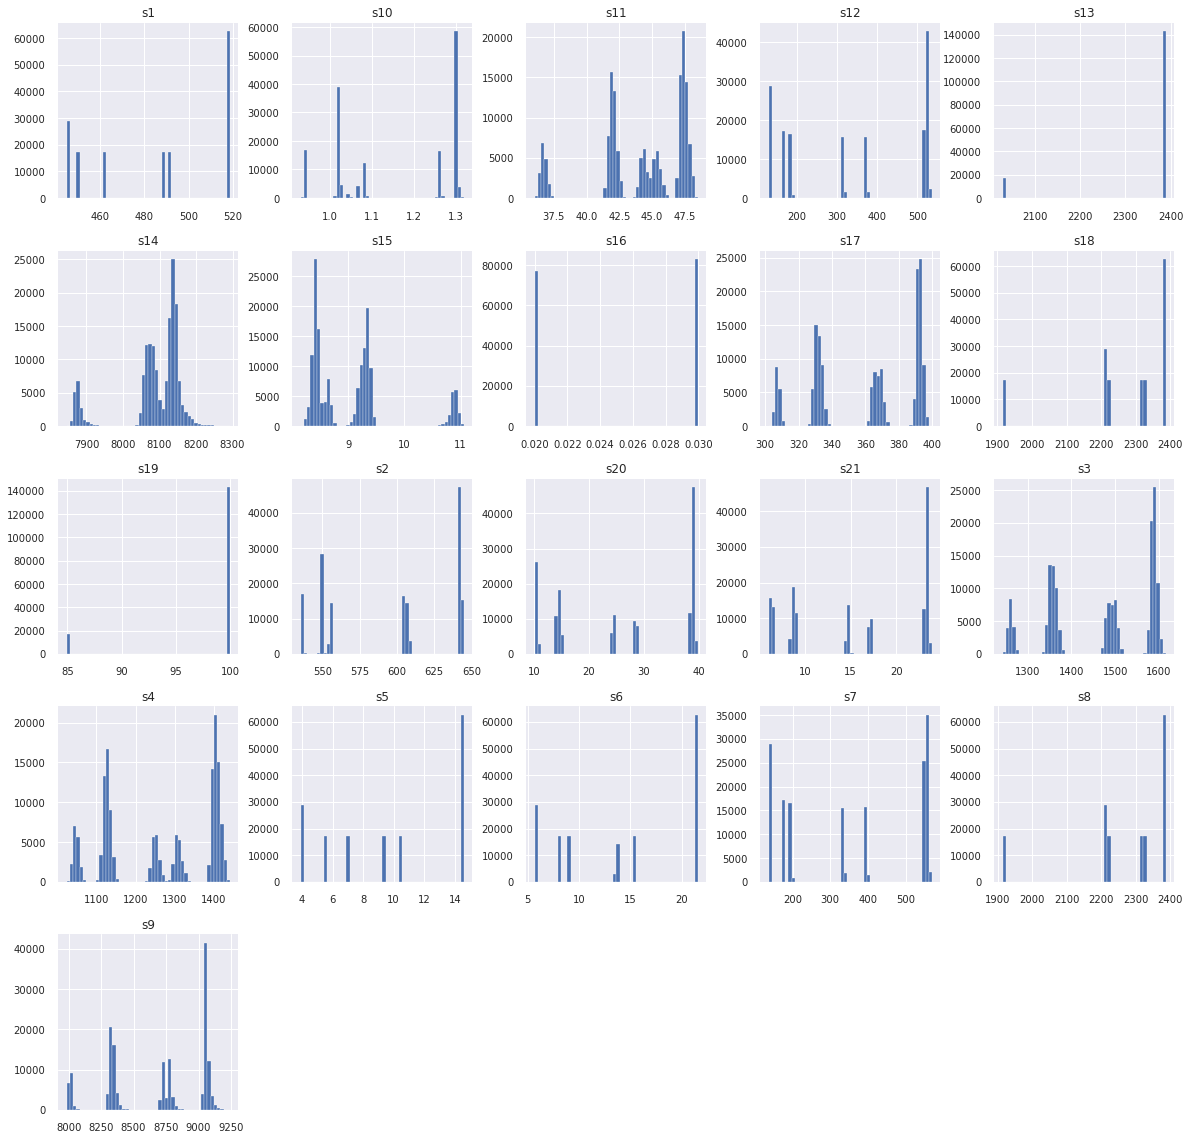

In [12]:
#histograms for each sensor column in df
sns.set_style("darkgrid")

hist = df[s_columns].hist(bins=50, figsize =(20,20))


**Takeaways:** There are several sensor readings that have only a handful of values. Like s13, s16, s19. Sensors with constant values will unlikely be a good predictor of the engine degradation.

## Identification and creation of Features

### Operating Regime

As we observed we have 6 operating regimes. Let's cluster the data and create a new variable *op_regime* which can replace the 3 op_settings

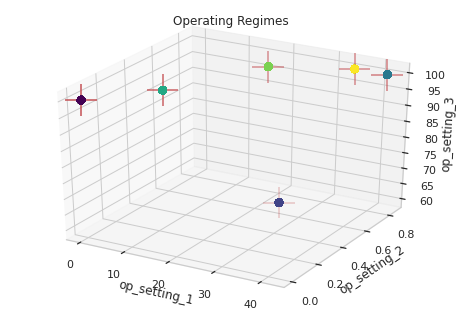

In [34]:
# This code will fit the k-means algorithm with our k parameter set to 6, and plot the results.
op_regimes = df[op_setting_columns].values
kmeans6 = KMeans(n_clusters=6)
y_kmeans6 = kmeans6.fit_predict(op_regimes)

centers = kmeans6.cluster_centers_

sns.set_style("whitegrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(op_regimes[:, 0], op_regimes[:, 1], op_regimes[:, 2], c=y_kmeans6, s=50, cmap='viridis', alpha=0.5)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], marker='+', c='r', s=1000)

ax.set_xlabel(op_setting_columns[0])
ax.set_ylabel(op_setting_columns[1])
ax.set_zlabel(op_setting_columns[2])
ax.set_title('Operating Regimes')
plt.show()

In [95]:
# Adding a op_regime column to the dataframe
df['op_regime'] = y_kmeans6+1

In [96]:
df.head()

,unit_number,cycle_time,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,dataset,RUL,op_regime
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8.4246,0.03,391,2388,100.0,39.11,23.3537,FD003,-258,1
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8.4403,0.03,392,2388,100.0,38.99,23.4491,FD003,-257,1
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8.3901,0.03,391,2388,100.0,38.85,23.3669,FD003,-256,1
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,8.3878,0.03,392,2388,100.0,38.96,23.2951,FD003,-255,1
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,8.3869,0.03,392,2388,100.0,39.14,23.4583,FD003,-254,1


**Questions :** Do mulitple operating regime occur in each dataset?

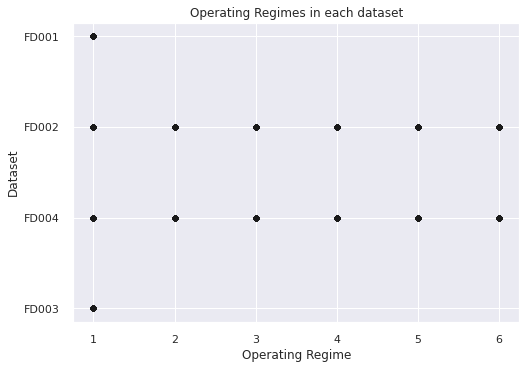

In [97]:
#plot distribution of operating regimes vs dataset
plt.scatter(df['op_regime'],df['dataset'],s=20,c='k')

plt.title('Operating Regimes in each dataset')
plt.xlabel('Operating Regime')
plt.ylabel('Dataset')
plt.savefig('figures/Op_regime_vs_dataset.png')
plt.show()

In [100]:
op_regime_list = df['op_regime'].unique()
op_regime_list

array([1, 3, 5, 2, 6, 4], dtype=int32)

In [105]:
op_regime_list = df['op_regime'].unique()
dataset_list = df['dataset'].unique()

for regime_choice in op_regime_list :
    # randomly select 10 units from dataset 1 to plot
    all_units = df[df['op_regime'] == regime_choice]['unit_number'].unique()
    units_to_plot = np.random.choice(all_units, size=10, replace=False)
    # get the data for these units
    plot_data = df[(df['unit_number'].isin(units_to_plot)) & df['op_regime'] == regime_choice].copy()
    # plot the sensor traces (overlaid)
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(21, 1, figsize=(5, 30), sharex=True)
    for index, ax in enumerate(axes.ravel()):
        s_col = s_columns[index]
        # use the same subset of data as above
        for unit_id, group in plot_data.groupby('unit_number'):
            # plot the raw sensor trace, using RUL on the time axis
            (group
                 .plot(x='RUL', y=s_col, alpha=0.45, ax=ax, color='gray', legend=False));
            # overlay the 10-cycle rolling mean sensor trace for visual clarity
            (group
                 .rolling(window=10, on='RUL')
                 .mean()
                 .plot(x='RUL', y=s_col, alpha=.75, ax=ax, color='black', legend=False));
        # label formatting
        ax.set_ylabel(s_col.title(), size=10);
        ax.set_xlabel("Remaining Usable Life (Cycles)")
        # add a vertical red line to signal common time of failure
        ax.axvline(x=0, color='r', linewidth=1)
        # extend the x-axis to compensate 
        ax.set_xlim([None, 10])
    image_title = "Op_regime "+str(regime_choice)+" (Random Sample of 10 Units)"
    fig.suptitle(image_title, size=20, y=1.025)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85) 
    fig_path = 'figures/'+str(regime_choice)+"_sensor_traces.png"
    fig.savefig(fig_path) 
    plt.close()


**Takeaway :** Dataset FD001 and FD003 feature data only for Operating regime #1.

### Remaining Usable Life (RUL)

Let's add a RUL column to the data. Translating the data so that the last cycle time for each time-series is 0.

In [28]:
# calculate maximum lifetime for each time-series
lifetimes = df.groupby(['dataset', 'unit_number'])['cycle_time'].max()

In [29]:

# calculate the Reamining Usable Life for each entry
# WARNING!! : This can take a minute or two
df['RUL'] = df.apply( lambda row : row["cycle_time"]-lifetimes.loc[row["dataset"]].loc[row["unit_number"]] , axis=1)

In [30]:
df.head()

,unit_number,cycle_time,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,dataset,RUL,op_regime
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8.4246,0.03,391,2388,100.0,39.11,23.3537,FD003,-258,2
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8.4403,0.03,392,2388,100.0,38.99,23.4491,FD003,-257,2
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8.3901,0.03,391,2388,100.0,38.85,23.3669,FD003,-256,2
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,8.3878,0.03,392,2388,100.0,38.96,23.2951,FD003,-255,2
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,8.3869,0.03,392,2388,100.0,39.14,23.4583,FD003,-254,2


### Sensor Selection

Let's look at what the sensor traces look like in each dataset.

In [106]:
dataset_list = df['dataset'].unique()

for dataset_choice in dataset_list :
    # randomly select 10 units from dataset 1 to plot
    all_units = df[df['dataset'] == dataset_choice]['unit_number'].unique()
    units_to_plot = np.random.choice(all_units, size=10, replace=False)
    # get the data for these units
    plot_data = df[(df['dataset'] == dataset_choice) & (df['unit_number'].isin(units_to_plot))].copy()
    # plot the sensor traces (overlaid)
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True)
    for index, ax in enumerate(axes.ravel()):
        s_col = s_columns[index]
        # use the same subset of data as above
        for unit_id, group in plot_data.groupby('unit_number'):
            # plot the raw sensor trace, using RUL on the time axis
            (group
                 .plot(x='RUL', y=s_col, alpha=0.45, ax=ax, color='gray', legend=False));
            # overlay the 10-cycle rolling mean sensor trace for visual clarity
            (group
                 .rolling(window=10, on='RUL')
                 .mean()
                 .plot(x='RUL', y=s_col, alpha=.75, ax=ax, color='black', legend=False));
        # label formatting
        if index % 3 == 0:
            ax.set_ylabel("Sensor Read", size=10);
        else:
            ax.set_ylabel("");
        ax.set_title(s_col.title())
        ax.set_xlabel("Remaining Usable Life (Cycles)")
        # add a vertical red line to signal common time of failure
        ax.axvline(x=0, color='r', linewidth=1)
        # extend the x-axis to compensate 
        ax.set_xlim([None, 10])
    image_title = "Dataset "+dataset_choice+" (Random Sample of 10 Units)"
    fig.suptitle(image_title, size=20, y=1.025)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig_path = 'figures/'+dataset_choice+"_sensor_traces.png"
    fig.savefig(fig_path) 
    plt.close()


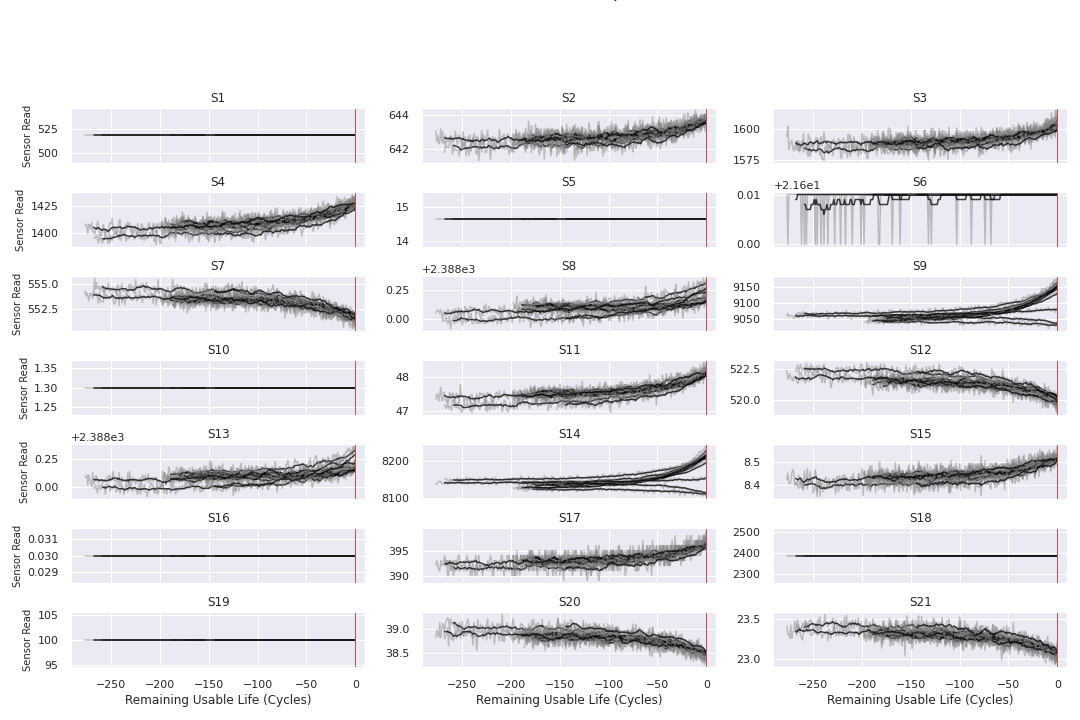

In [107]:
Image(filename='figures/FD001_sensor_traces.png') 

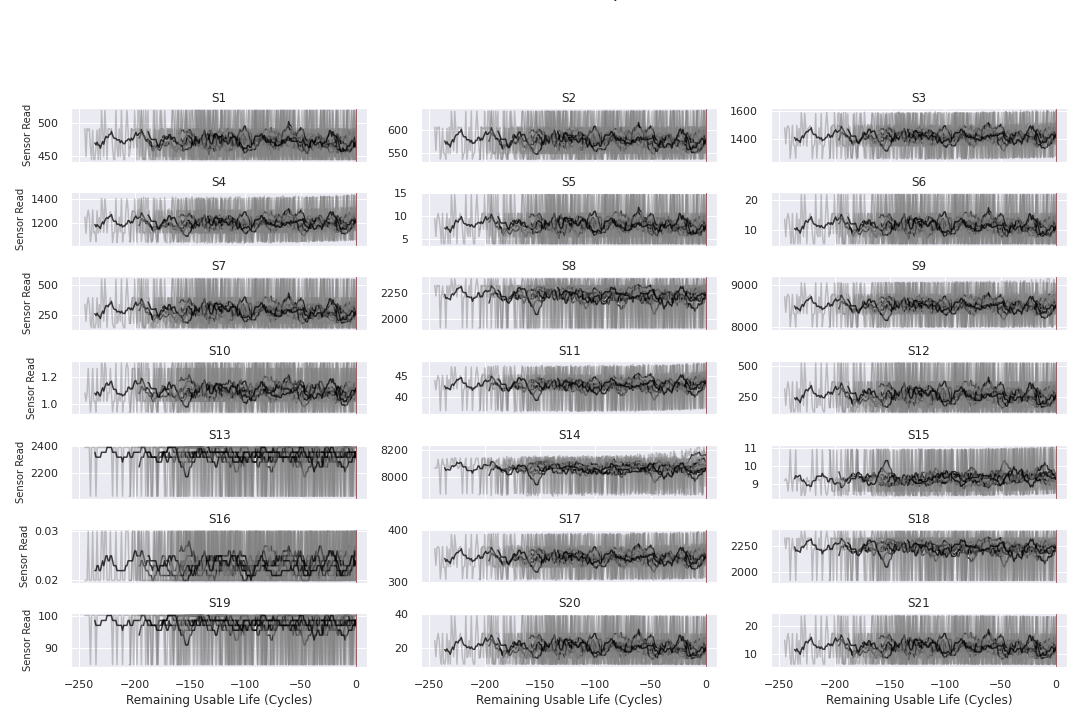

In [108]:
Image(filename='figures/FD002_sensor_traces.png') 

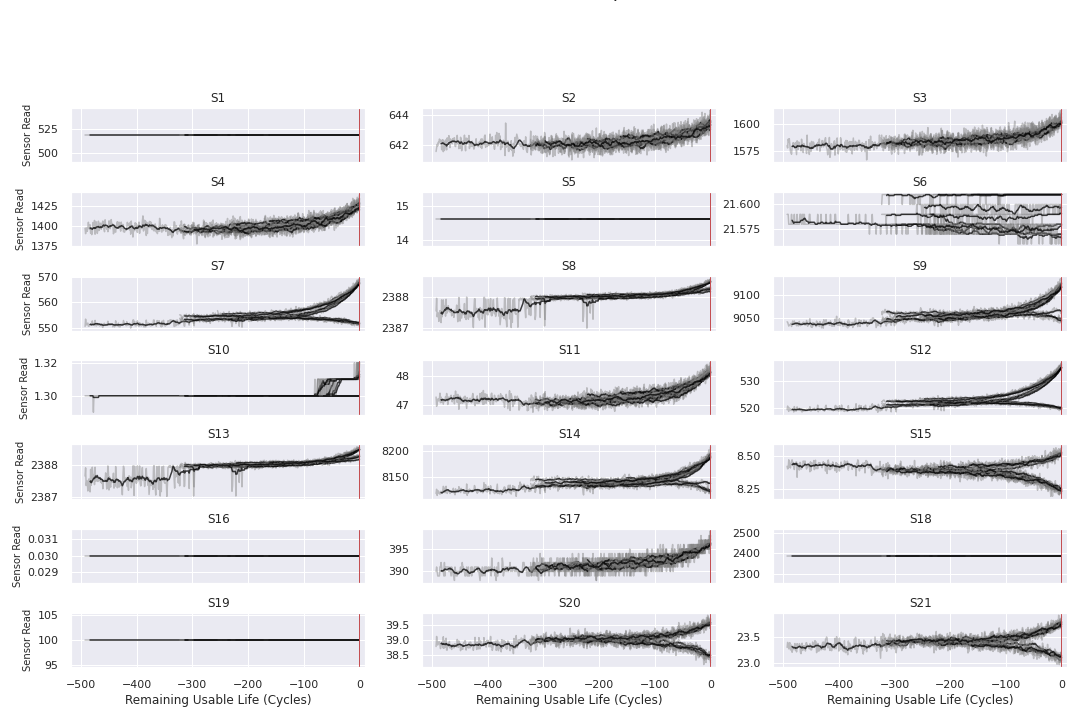

In [109]:
Image(filename='figures/FD003_sensor_traces.png') 

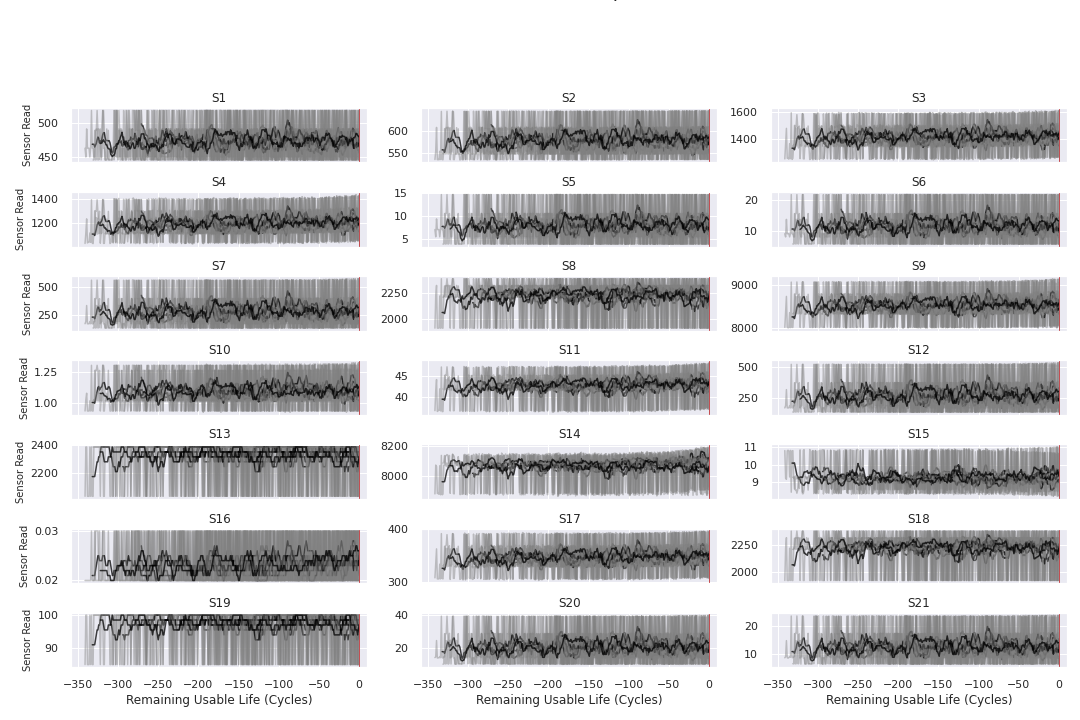

In [110]:
Image(filename='figures/FD004_sensor_traces.png') 

**Takeaways :** Each dataset has distinctively different sensor profiles. In FD003 and FD004 are difficult to interpret, most sensors do not exhibit any obvious trend that might be a sign of degradation. In FD001 and FD002 we can weed out several sensors where the value is constant. In FD001 for example we could remove from the models sensors s1, s5, s10, s16, s18, s19 as their value does not change at all from cycle to cycle.



## EDA Conclusions



To begin with we will concentrate our efforts on modelling operating regime #1, thus we will only use dataset FD001 to begin with. Based on the findings we can expand and attempt to work with the other datasets as well. 

In [ ]:
train_op_regime2_FD001